**This notebook demonstrates tomography**
$$
   \newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
   \newcommand{\ket}[1]{\left|{#1}\right\rangle}
   \newcommand{\bra}[1]{\left\langle{#1}\right|}
$$

A single qubit can be viewed as a unit vector in the Bloch sphere *i.e.* it lies on the unit sphere.

The density matrix form of a pure state $\ket{\psi}$ is given by:
$$
\ket{\psi}\bra{\psi} = \left(I
+ \left\langle X \right\rangle X 
+ \left\langle Y \right\rangle Y 
+ \left\langle Z \right\rangle Z
\right)
$$
where the components are the expectation values of the Pauli operators:
$$
\begin{align}
\left\langle X \right\rangle &= \mathsf{tr}\left(\ket{\psi}\bra{\psi}X\right)\\
\left\langle Y \right\rangle &= \mathsf{tr}\left(\ket{\psi}\bra{\psi}X\right)\\
\left\langle Z \right\rangle &= \mathsf{tr}\left(\ket{\psi}\bra{\psi}X\right)\\
\end{align}.
$$
For pure states the Bloch vector has length 1, so;
$$
\left|\left\langle X \right\rangle\right|^2 +
\left|\left\langle Y \right\rangle\right|^2 +
\left|\left\langle Z \right\rangle\right|^2 = 1.
$$

The Pauli operators are:
$$
\begin{align}
X &= \ket{1}\bra{0} + \ket{0}\bra{1} = 
\begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix}\\
Y &= -\ket{1}\bra{0} + \ket{0}\bra{1} = 
\begin{pmatrix}
0 & 1\\
-1 & 0
\end{pmatrix}\\
Z &= \ket{0}\bra{0} - \ket{1}\bra{1} = 
\begin{pmatrix}
1 & 0\\
0 & -1
\end{pmatrix}
\end{align}.
$$
We can reconstruct an arbitrary unknown qubit by measuring its vector components on the Bloch sphere:
1. Measure along all three axes:
    - Measurement in Z is straightforward
    - To measure in X, use the Hadamard gate to exchange Z and X
    - To measure in Y, use $S^\dagger$ followed by $H$ to exchange Z and Y
2. From the measurements, compute the expectation values:
$$
\begin{align}
\left\langle X \right\rangle &= P_X(0) - P_X(1)\\
\left\langle Y \right\rangle &= P_Y(0) - P_Y(1)\\
\left\langle Z \right\rangle &= P_Z(0) - P_Z(1)\\
\end{align}
$$
3. Construct the unknown state:
$$
\ket{\psi}\bra{\psi} = \left(I
+ \left\langle X \right\rangle X 
+ \left\langle Y \right\rangle Y 
+ \left\langle Z \right\rangle Z
\right)
$$


*Example: simple tomography*
1. Construct a series of circuits, with increasing phase $\lambda$
2. Measure each circuit along the $X$, $Y$ and $Z$ axes.

In [1]:
import os, sys
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.visualization import plot_bloch_vector
import numpy as np

# Import local tools
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import backend_tools

# Get a backend
IBMQ.load_accounts()
simulator = backend_tools.get_device(use_sim=True, min_qubits=2)

In [2]:
# Define the Quantum and Classical Registers
q = QuantumRegister(1)
c = ClassicalRegister(1)

# Build the circuits
pre = QuantumCircuit(q, c)
pre.h(q)
pre.barrier()

meas_x = QuantumCircuit(q, c)
meas_x.barrier()
meas_x.h(q)
meas_x.measure(q, c)

meas_y = QuantumCircuit(q, c)
meas_y.barrier()
meas_y.s(q).inverse()
meas_y.h(q)
meas_y.measure(q, c)

meas_z = QuantumCircuit(q, c)
meas_z.barrier()
meas_z.measure(q, c)

bloch_vector = ['x', 'y', 'z']
exp_vector = range(0, 11)
circuits = []
for exp_index in exp_vector:
    middle = QuantumCircuit(q, c)
    phase = 2*np.pi*exp_index/(len(exp_vector)-1)
    middle.u1(phase, q)
    circuits.append(pre + middle + meas_x)
    circuits.append(pre + middle + meas_y)
    circuits.append(pre + middle + meas_z)
    
# Draw one of the circuits
#%matplotlib inline
style = {'backgroundcolor': 'lightgreen'}
#circuits[7].draw(output='mpl', plot_barriers=True, reverse_bits=True, style=style, scale=0.6)

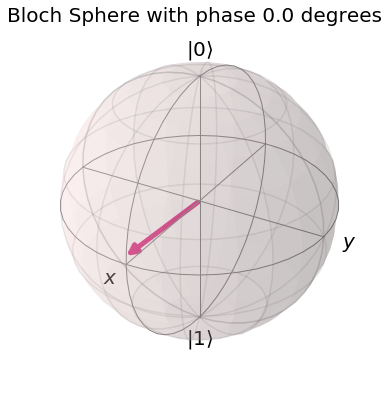

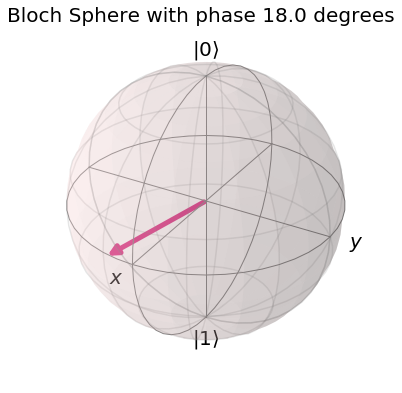

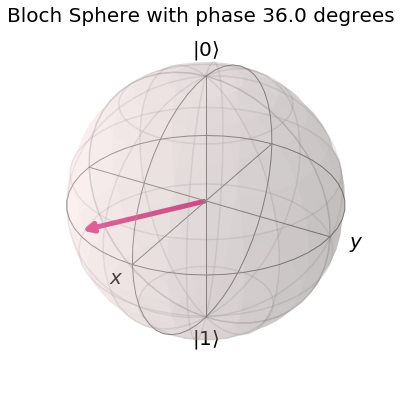

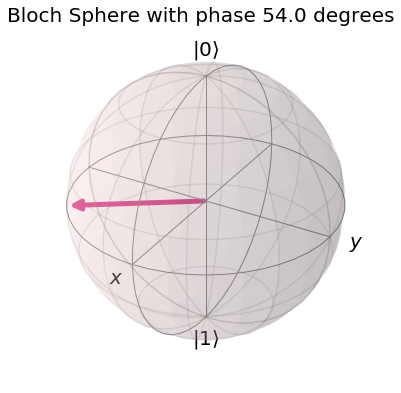

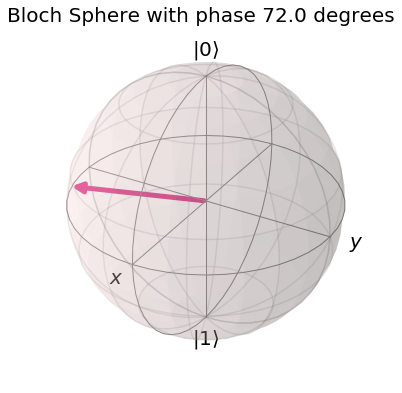

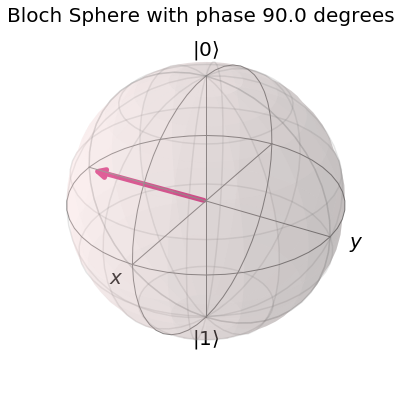

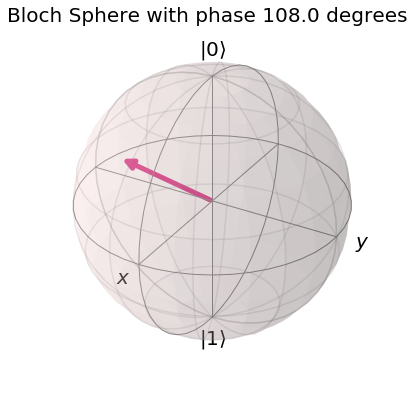

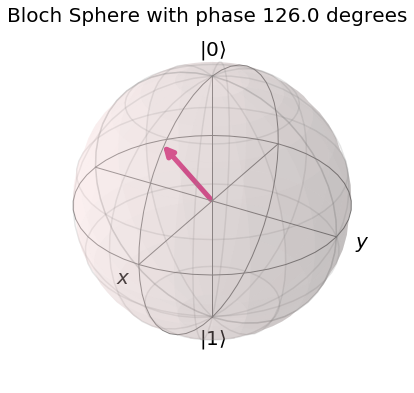

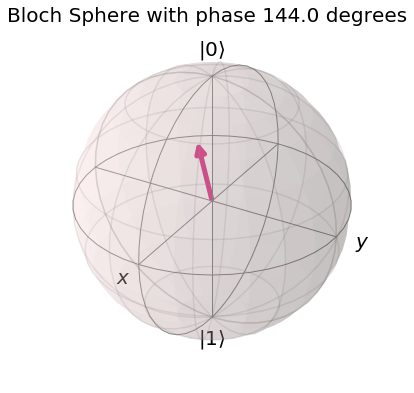

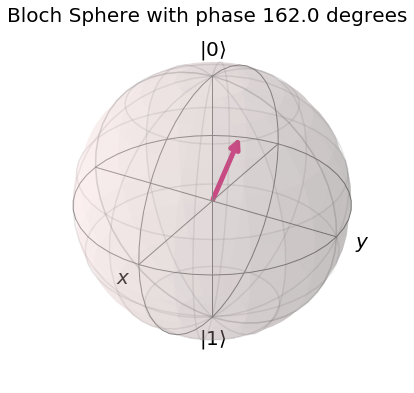

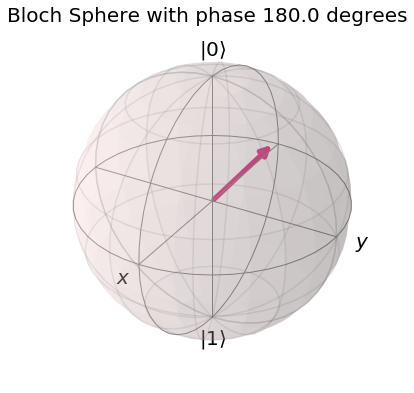

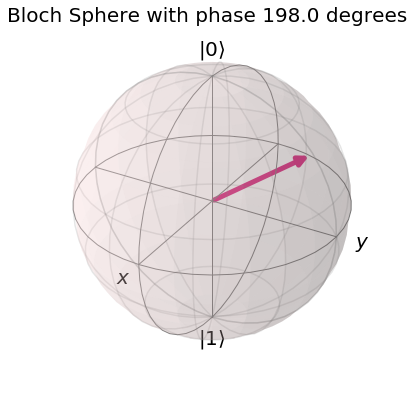

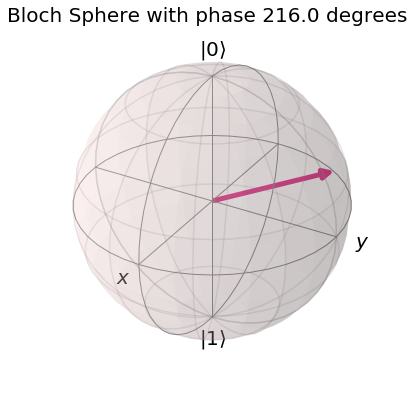

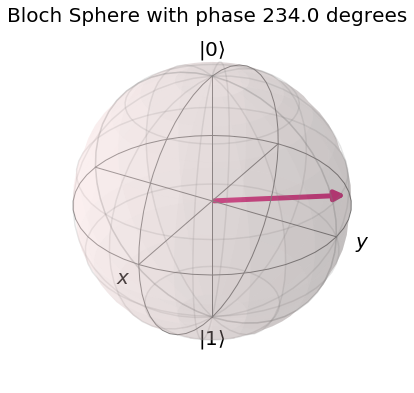

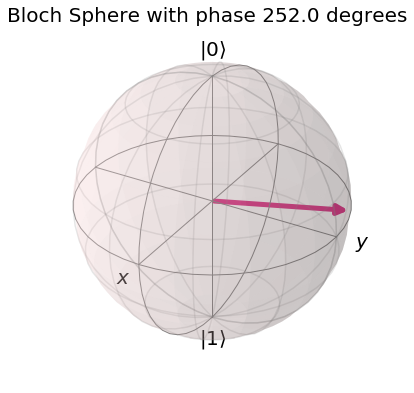

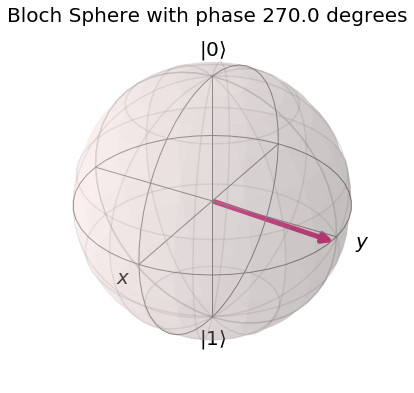

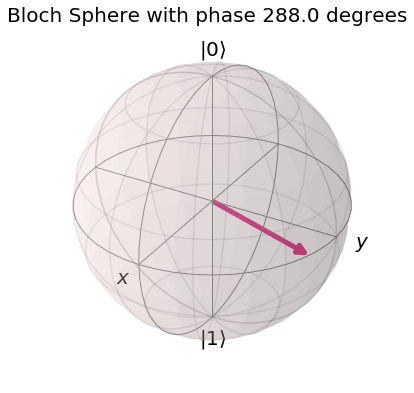

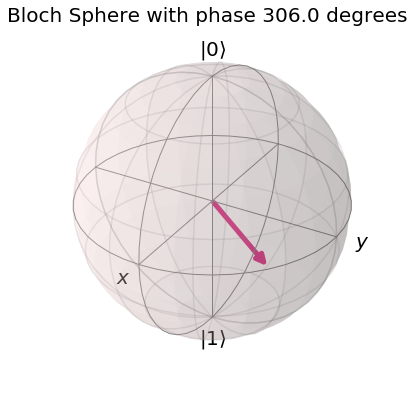

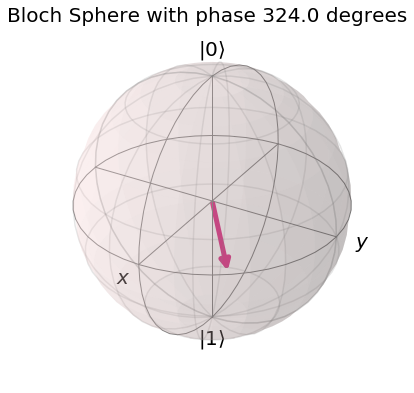

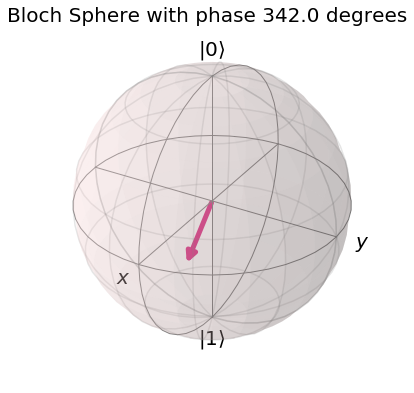

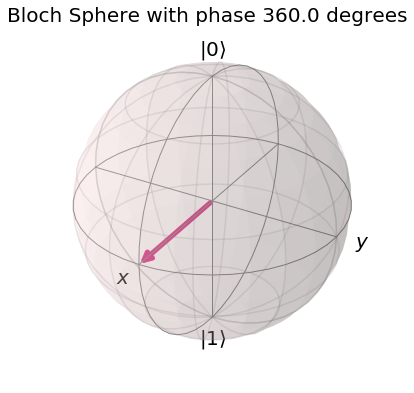

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_figure(fig):
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    plt.show(fig)

# Execute the circuit
job = execute(circuits, backend=simulator, shots=1024)
result = job.result()

from qiskit.tools.visualization import plot_bloch_vector
# Plot the result
for exp_index in exp_vector:
    phase = 2*np.pi*exp_index/(len(exp_vector)-1)
    phase_deg = phase / (2.0*np.pi) * 360.0
    bloch = [0, 0, 0]
    for bloch_index in range(len(bloch_vector)):
        data = result.get_counts(circuits[3*exp_index+bloch_index])
        try:
            p0 = data['0']/1024.0
        except KeyError:
            p0 = 0
        try:
            p1 = data['1']/1024.0
        except KeyError:
            p1 = 0
        bloch[bloch_index] = p0-p1
    show_figure(plot_bloch_vector(bloch, title='Bloch Sphere with phase {:.1f} degrees'.format(phase_deg)))